# Задача 6

## Одинарное судоку

**x(i,j,k)** – значение на пересечении строки i и столбца j равно значению k
> Всего переменных: i x j x k = 9 x 9 x 9 = 729

**Ограничения:**

**1. Для каждой ячейки** (ровно одно число в ячейке): ∑_k x(i,j,k) = 1
> x[i,j,1] + x[i,j,2] + ... + x[i,j,9] = 1

**2. Для строк** (число k встречается в строке 1 раз): ∑_i x(i,j,k) = 1
> x[i,1,k] + x[i,2,k] + ... + x[i,9,k] = 1

**3. Для столбцов** (число k встречается в столбце 1 раз): ∑_j x(i,j,k) = 1
> x[1,j,k] + x[2,j,k] + ... + x[9,j,k] = 1

**4. Для квадратов 3×3** (число k встречается в квадрате 1 раз): ∑(3u)_j=3(u-1)+1 ∑(3V)_i=3(V-1)+1 x(i,j,k) = 1
> sum(x[i,j,k] для всех i,j в квадрате) = 1

In [1]:
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Matplotlib is building the font cache; this may take a moment.


**Индексация**

i x 81 + j x 9 + k

**i** — 81, так как каждая строка содержит 81 переменную (9 столбцов × 9 чисел)

**j** — 9, так как в каждом столбце 9 чисел

**k** — число (0..8) → добавляем как есть

In [14]:
def solve_sudoku(grid):
    # Создаем переменные: x[i,j,k] = 1 если в ячейке (i,j) число k
    num_vars = 9*9*9
    
    # Целевая функция (фиктивная, так как нам нужно только выполнить ограничения)
    c = np.zeros(num_vars)
    
    # Ограничения равенства (Ax = b)
    A_eq = []
    b_eq = []

    '''
    1. Каждая ячейка содержит ровно одно число
    Пример:
    i=0, j=0
    x_000 + x_001 + ... + x_008 = 1
    A_eq: [1,1,1,1,1,1,1,1,1,0,0, ... ,0]
    '''
    for i in range(9):
        for j in range(9):
            constraint = np.zeros(num_vars)
            for k in range(9):
                constraint[i*81 + j*9 + k] = 1
            A_eq.append(constraint)
            b_eq.append(1)
    
    '''
    2. Каждое число встречается ровно один раз в строке
    Пример:
    i=0, k=0
    x_000 + x_010 + x_020 + ... + x_080 = 1
    A_eq: [1,0,0,0,0,0,0,0,0,1,...]
    коэффициенты 1 на позициях 0×81 + j×9 + 0 для j={0, 8}
    '''
    for i in range(9):
        for k in range(9):
            constraint = np.zeros(num_vars)
            for j in range(9):
                constraint[i*81 + j*9 + k] = 1
            A_eq.append(constraint)
            b_eq.append(1)
    
    '''
    3. Каждое число встречается ровно один раз в столбце
    Пример:
    j=0, k=0
    x_000 + x_100 + x_200 + ... + x_800 = 1
    A_eq: [1,через 80 0,1, ...]
    коэффициенты 1 на позициях i×81 + 0×9 + 0 для i={0, 8}
    '''
    for j in range(9):
        for k in range(9):
            constraint = np.zeros(num_vars)
            for i in range(9):
                constraint[i*81 + j*9 + k] = 1
            A_eq.append(constraint)
            b_eq.append(1)
    
    '''
    4. Каждое число встречается ровно один раз в квадрате 3x3
    Пример:
    Блок 0 (верхний левый), k=0
    Коэффициенты для x_ijk (где i, j принадлежат блоку) равны 1
    x_000 + x_010 + x_020 + x_100 + x_110 + x_120 + x_200 + x_210 + x_220 = 1
    A_eq: [1,0,0,1,0,0,1,0,0,...]
    коэффициенты 1 на позициях i×81 + j×9 + 0 для i={0, 2}, j={0, 2}
    '''
    for block in range(9):
        '''
        По вертикали: 3 ряда блоков (0–2, 3–5, 6–8)
        По горизонтали: 3 столбца блоков (0–2, 3–5, 6–8)
        block // 3 определяет номер строки блока (0, 1 или 2)
        Умножение на 3 даёт начальную строку ячеек в сетке
        '''
        br = (block // 3) * 3
        bc = (block % 3) * 3
        for k in range(9):
            constraint = np.zeros(num_vars)
            for i in range(br, br+3):
                for j in range(bc, bc+3):
                    constraint[i*81 + j*9 + k] = 1
            A_eq.append(constraint)
            b_eq.append(1)
    
    # Преобразуем в массивы numpy
    A_eq = np.array(A_eq)
    b_eq = np.array(b_eq)
    
    # Границы переменных (0 <= x <= 1)
    bounds = [(0, 1)] * num_vars
    
    '''
    Фиксируем известные значения
    Если в исходной сетке Sudoku в ячейке (i ,j) уже задано число m, то добавляется ограничение: x_ij(m−1)=1
    Пример:
    если в ячейке (0, 0) стоит 5, то:
    x_004=1
    Соответствующая строка в A_eq:[0,0,0,0,1,0,0,0,0,0,...,0]
    коэффициент 1 на позиции 0×81+0×9+4
    '''
    for i in range(9):
        for j in range(9):
            if grid[i][j] != 0:
                k = grid[i][j] - 1  # Приводим к привычной индексации
                constraint = np.zeros(num_vars)
                constraint[i*81 + j*9 + k] = 1
                A_eq = np.vstack([A_eq, constraint])
                b_eq = np.append(b_eq, 1)
    
    # Решаем задачу линейного программирования
    res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
    
    if not res.success:
        raise ValueError("Не удалось найти решение судоку")
    
    # Извлекаем решение
    solution = np.zeros((9, 9), dtype=int)
    for i in range(9):
        for j in range(9):
            for k in range(9):
                if res.x[i*81 + j*9 + k] > 0.5:  # Учитываем погрешность
                    solution[i][j] = k + 1  # Возвращаем к 1-индексации
    return solution
   

In [21]:
def plot_sudoku(grid, title="Sudoku"):
    """Визуализирует судоку"""
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))
    ax.grid(which='both', color='black', linewidth=1)
    ax.set_xticks(np.arange(0, 10, 3), minor=True)
    ax.set_yticks(np.arange(0, 10, 3), minor=True)
    ax.grid(which='minor', color='black', linewidth=2)
    ax.set_title(title)
    ax.invert_yaxis()
    
    for i in range(9):
        for j in range(9):
            if grid[i][j] != 0:
                ax.text(j + 0.5, i + 0.5, str(grid[i][j]), 
                        ha='center', va='center', fontsize=16)
    
    plt.show()

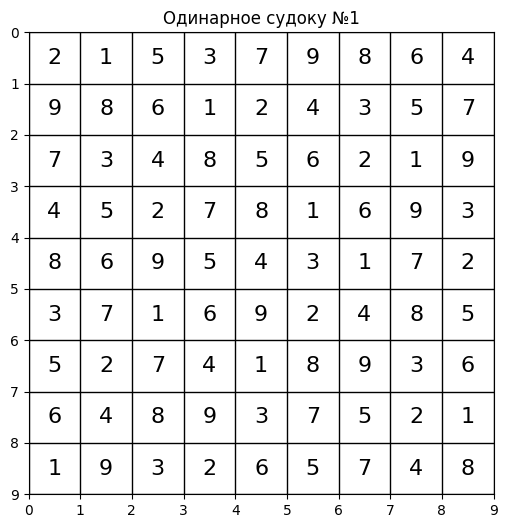

In [24]:
single_sudoku = [
    [2, 0, 5, 0, 0, 9, 0, 0, 4],
    [0, 0, 0, 0, 0, 0, 3, 0, 7],
    [7, 0, 0, 8, 5, 6, 0, 1, 0],
    [4, 5, 0, 7, 0, 0, 0, 0, 0],
    [0, 0, 9, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 2, 0, 8, 5],
    [0, 2, 0, 4, 1, 8, 0, 0, 6],
    [6, 0, 8, 0, 0, 0, 0, 0, 0],
    [1, 0, 0, 2, 0, 0, 7, 0, 8]
]
solution1 = solve_sudoku(single_sudoku)
plot_sudoku(solution1, "Одинарное судоку №1")

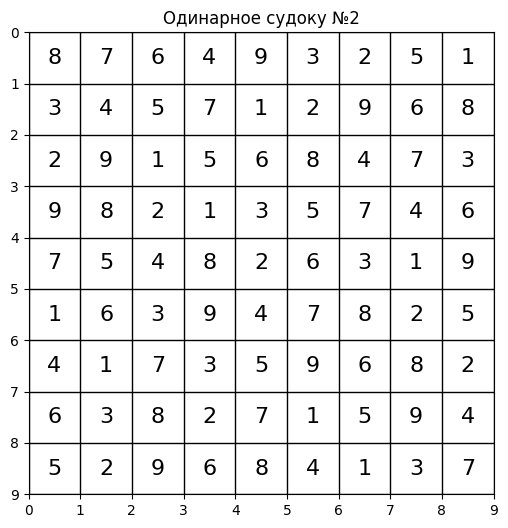

In [25]:
single_sudoku2 = [
    [0, 0, 6, 0, 9, 0, 2, 0, 0],
    [0, 0, 0, 7, 0, 2, 0, 0, 0],
    [0, 9, 0, 5, 0, 8, 0, 7, 0],
    [9, 0, 0, 0, 3, 0, 0, 0, 6],
    [7, 5, 0, 0, 0, 0, 0, 1, 9],
    [1, 0, 0, 0, 4, 0, 0, 0, 5],
    [0, 1, 0, 3, 0, 9, 0, 8, 0],
    [0, 0, 0, 2, 0, 1, 0, 0, 0],
    [0, 0, 9, 0, 8, 0, 1, 0, 0]
]
solution2 = solve_sudoku(single_sudoku2)
plot_sudoku(solution2, "Одинарное судоку №2")

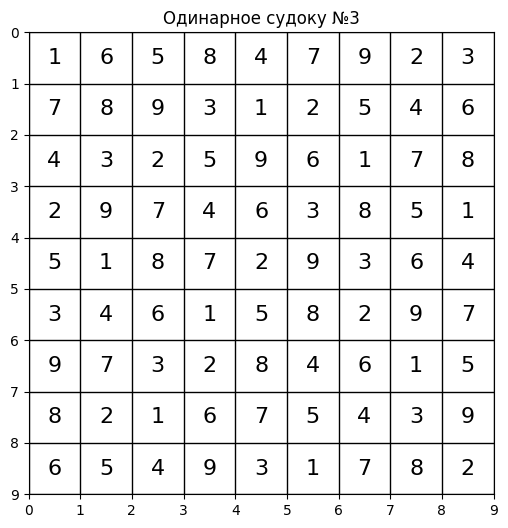

In [26]:
single_sudoku3 = [
    [0, 0, 0, 8, 0, 0, 0, 0, 0],
    [7, 8, 9, 0, 1, 0, 0, 0, 6],
    [0, 0, 0, 0, 0, 6, 1, 0, 0],
    [0, 0, 7, 0, 0, 0, 0, 5, 0],
    [5, 0, 8, 7, 0, 9, 3, 0, 4],
    [0, 4, 0, 0, 0, 0, 2, 0, 0],
    [0, 0, 3, 2, 0, 0, 0, 0, 0],
    [8, 0, 0, 0, 7, 0, 4, 3, 9],
    [0, 0, 0, 0, 0, 1, 0, 0, 0]
]
solution3 = solve_sudoku(single_sudoku3)
plot_sudoku(solution3, "Одинарное судоку №3")

## N-судоку

Всего переменных: Nx9x9x9

N - количество судоку

Те же ограничения для каждого судоку, что и в одинарном.


In [5]:
def solve_n_sudoku(grids, common_blocks):
    N = len(grids)
    num_vars = N * 9*9*9
    c = np.zeros(num_vars)
    A_eq, b_eq = [], []

    # Проверка на дубликаты
    for n, grid in enumerate(grids):
        for i in range(9):
            row = [x for x in grid[i] if x != 0]
            if len(row) != len(set(row)):
                raise ValueError(f"Дубликаты в строке {i+1} судоку {n+1}")
        
        for j in range(9):
            col = [grid[i][j] for i in range(9) if grid[i][j] != 0]
            if len(col) != len(set(col)):
                raise ValueError(f"Дубликаты в столбце {j+1} судоку {n+1}")
        
        for block in range(9):
            br, bc = (block//3)*3, (block%3)*3
            block_values = [grid[i][j] for i in range(br, br+3) for j in range(bc, bc+3) if grid[i][j] != 0]
            if len(block_values) != len(set(block_values)):
                raise ValueError(f"Дубликаты в блоке {block+1} судоку {n+1}")

    # Ограничения для каждой сетки
    for n in range(N):
        offset = n * 9*9*9
        for i in range(9):
            for j in range(9):
                constraint = np.zeros(num_vars)
                for k in range(9):
                    if grids[n][i][j] == 0 or grids[n][i][j] == k+1:
                        constraint[offset + i*81 + j*9 + k] = 1
                A_eq.append(constraint)
                b_eq.append(1)
        
        for i in range(9):
            for k in range(9):
                constraint = np.zeros(num_vars)
                for j in range(9):
                    if grids[n][i][j] == 0 or grids[n][i][j] == k+1:
                        constraint[offset + i*81 + j*9 + k] = 1
                A_eq.append(constraint)
                b_eq.append(1)
        
        for j in range(9):
            for k in range(9):
                constraint = np.zeros(num_vars)
                for i in range(9):
                    if grids[n][i][j] == 0 or grids[n][i][j] == k+1:
                        constraint[offset + i*81 + j*9 + k] = 1
                A_eq.append(constraint)
                b_eq.append(1)
        
        for block in range(9):
            br, bc = (block//3)*3, (block%3)*3
            for k in range(9):
                constraint = np.zeros(num_vars)
                for i in range(br, br+3):
                    for j in range(bc, bc+3):
                        if grids[n][i][j] == 0 or grids[n][i][j] == k+1:
                            constraint[offset + i*81 + j*9 + k] = 1
                A_eq.append(constraint)
                b_eq.append(1)
    
    # Ограничения на общие блоки
    for n1, b1_row, b1_col, n2, b2_row, b2_col in common_blocks:
        offset1, offset2 = n1*9*9*9, n2*9*9*9
        for i in range(3):
            for j in range(3):
                val1 = grids[n1][b1_row*3+i][b1_col*3+j]
                val2 = grids[n2][b2_row*3+i][b2_col*3+j]
                if val1 != 0 and val2 != 0 and val1 != val2:
                    raise ValueError(f"Конфликт в общем блоке: ({n1+1},{b1_row*3+i+1},{b1_col*3+j+1})={val1} vs ({n2+1},{b2_row*3+i+1},{b2_col*3+j+1})={val2}")

                for k in range(9):
                    constraint = np.zeros(num_vars)
                    if val1 == 0 or val1 == k+1:
                        constraint[offset1 + (b1_row*3+i)*81 + (b1_col*3+j)*9 + k] = 1
                    if val2 == 0 or val2 == k+1:
                        constraint[offset2 + (b2_row*3+i)*81 + (b2_col*3+j)*9 + k] = -1
                    A_eq.append(constraint)
                    b_eq.append(0)
    
    # Решение
    res = linprog(c, A_eq=np.array(A_eq), b_eq=np.array(b_eq), bounds=[(0,1)]*num_vars, method='highs')
    if not res.success:
        res = linprog(c, A_eq=np.array(A_eq), b_eq=np.array(b_eq), bounds=[(0,1)]*num_vars, method='interior-point')
        if not res.success:
            raise ValueError("Решение не найдено")

    solutions = []
    for n in range(N):
        solution = np.zeros((9,9), dtype=int)
        offset = n * 9*9*9
        for i in range(9):
            for j in range(9):
                for k in range(9):
                    if res.x[offset + i*81 + j*9 + k] > 0.5:
                        solution[i][j] = k + 1
        solutions.append(solution)
    
    return solutions

def expand_overlaps_to_linked_cells(common_blocks):
    """
    Преобразует общие блоки в связанные ячейки.
    Возвращает список словарей с информацией о пересечениях.
    """
    overlaps = []
    for n1, b1_row, b1_col, n2, b2_row, b2_col in common_blocks:
        overlaps.append({
            'sudoku1': n1,
            'block1': (b1_row, b1_col),
            'sudoku2': n2,
            'block2': (b2_row, b2_col),
            'cells': [(i, j) for i in range(3) for j in range(3)]
        })
    return overlaps

def build_sudoku_layout(num_sudokus, overlaps):
    """
    Строит расположение судоку на плоскости с учетом пересечений.
    Возвращает словарь {номер_судоку: (row, col)}.
    """
    layout = {}
    layout[0] = (0, 0)
    cell_size = 9
    positions = {0: (0, 0)}
    occupied = set()

    def get_block_position(pos, block):
        return (pos[0] + block[0]*3, pos[1] + block[1]*3)

    queue = [0]
    while queue:
        current = queue.pop(0)
        current_pos = positions[current]

        for overlap in overlaps:
            if overlap['sudoku1'] == current and overlap['sudoku2'] not in positions:
                pos1 = get_block_position(current_pos, overlap['block1'])
                pos2_offset = (pos1[0] - overlap['block2'][0]*3, pos1[1] - overlap['block2'][1]*3)
                positions[overlap['sudoku2']] = pos2_offset
                queue.append(overlap['sudoku2'])
            elif overlap['sudoku2'] == current and overlap['sudoku1'] not in positions:
                pos2 = get_block_position(current_pos, overlap['block2'])
                pos1_offset = (pos2[0] - overlap['block1'][0]*3, pos2[1] - overlap['block1'][1]*3)
                positions[overlap['sudoku1']] = pos1_offset
                queue.append(overlap['sudoku1'])

    min_row = min(pos[0] for pos in positions.values())
    min_col = min(pos[1] for pos in positions.values())

    layout = {k: (v[0] - min_row, v[1] - min_col) for k, v in positions.items()}
    return layout

In [6]:
def plot_sudoku_grids(grids, overlaps):
    num_sudokus = len(grids)
    layout = build_sudoku_layout(num_sudokus, overlaps)
    
    all_rows = [pos[0] for pos in layout.values()] + [pos[0] + 9 for pos in layout.values()]
    all_cols = [pos[1] for pos in layout.values()] + [pos[1] + 9 for pos in layout.values()]
    min_row, max_row = min(all_rows), max(all_rows)
    min_col, max_col = min(all_cols), max(all_cols)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xlim(min_col - 1, max_col + 1)
    ax.set_ylim(min_row - 1, max_row + 1)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    
    # Сначала рисуем все общие блоки
    common_cells = set()
    for overlap in overlaps:
        s1, b1_row, b1_col = overlap['sudoku1'], overlap['block1'][0], overlap['block1'][1]
        s2, b2_row, b2_col = overlap['sudoku2'], overlap['block2'][0], overlap['block2'][1]
        
        for i in range(3):
            for j in range(3):
                common_cells.add((s1, b1_row*3 + i, b1_col*3 + j))
                common_cells.add((s2, b2_row*3 + i, b2_col*3 + j))
    
    # Рисуем сетку и цифры
    for sudoku_idx in range(num_sudokus):
        grid = grids[sudoku_idx]
        offset_row, offset_col = layout[sudoku_idx]
        
        for i in range(9):
            for j in range(9):
                # Рисуем ячейку
                is_common = (sudoku_idx, i, j) in common_cells
                rect = patches.Rectangle(
                    (offset_col + j, offset_row + i), 
                    1, 1, 
                    linewidth=2 if is_common else 1,
                    edgecolor='blue' if is_common else 'black',
                    facecolor='none'
                )
                ax.add_patch(rect)
                
                # Цифры
                if grid[i][j] != 0:
                    ax.text(
                        offset_col + j + 0.5, 
                        offset_row + i + 0.5, 
                        str(grid[i][j]),
                        ha='center', 
                        va='center', 
                        color='blue' if is_common else 'black', 
                        fontsize=12
                    )
    
    plt.tight_layout()
    plt.show()

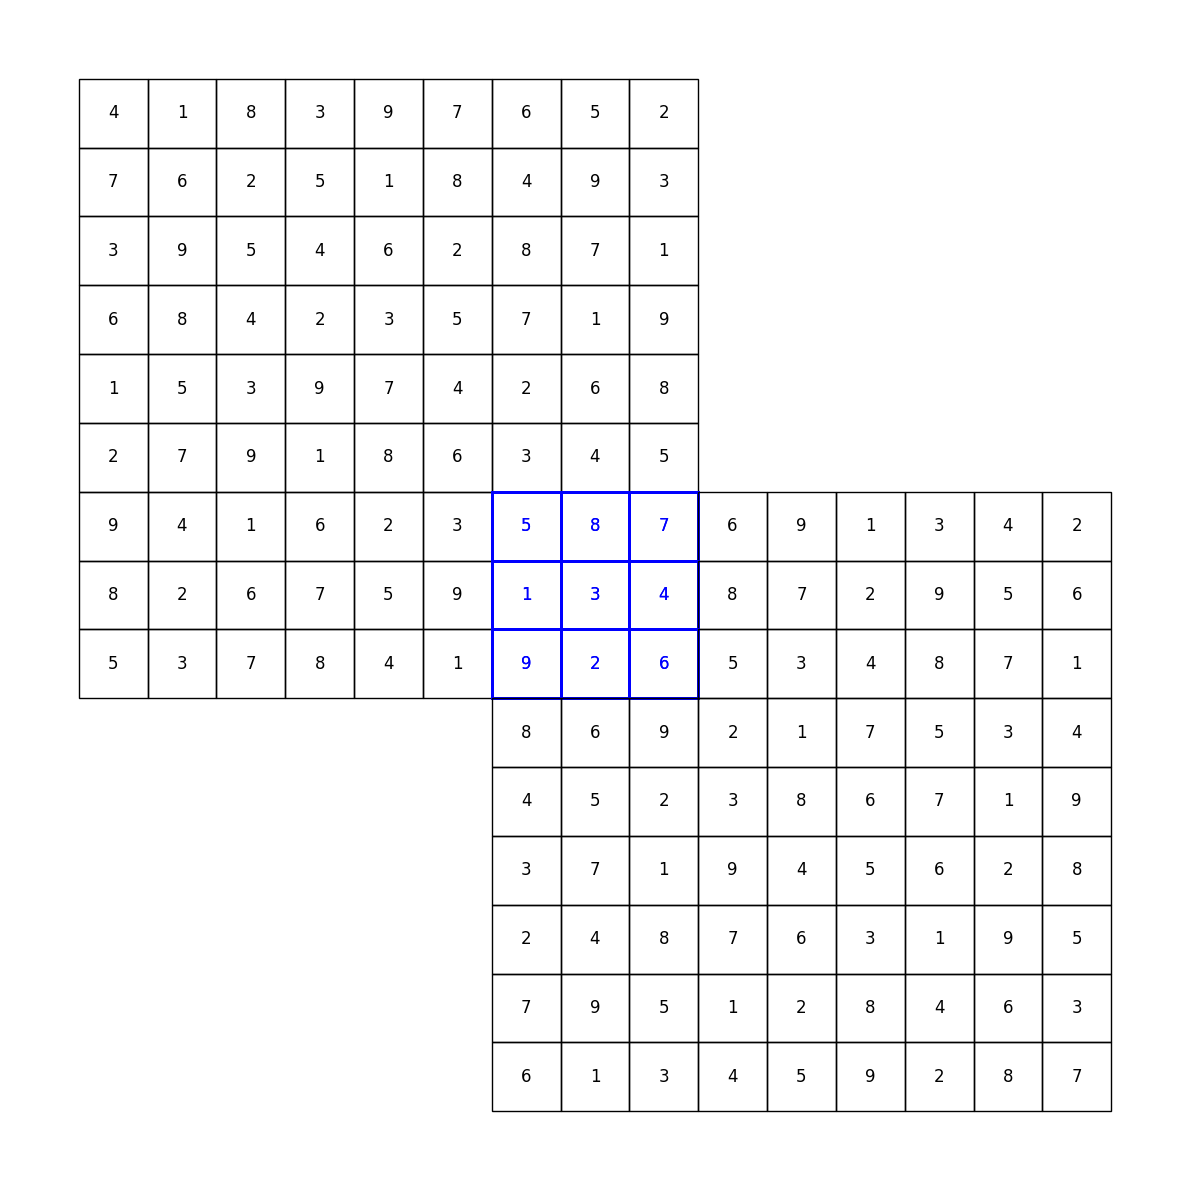

In [8]:
grid1 = [
    [4,0,8,3,0,0,0,0,2],
    [7,6,0,0,0,0,0,9,0],
    [0,0,5,0,0,0,8,7,1],
    [0,0,0,2,0,0,0,0,0],
    [0,5,0,9,7,4,0,6,0],
    [0,7,0,0,0,6,0,0,0],
    [0,4,1,0,0,0,0,0,0],
    [8,0,0,0,0,0,1,0,4],
    [5,0,0,0,0,1,9,0,0]
]

grid2 = [
    [0,0,0,6,9,0,0,4,2],
    [1,0,4,8,0,0,0,0,0],
    [9,0,0,0,0,0,8,0,1],
    [8,6,0,2,0,7,0,0,4],
    [0,0,0,3,8,6,0,0,0],
    [3,0,0,9,4,5,0,2,8],
    [2,0,8,0,0,0,1,0,5],
    [7,0,0,0,0,0,4,0,3],
    [6,1,0,0,5,9,0,0,0]
]

common_blocks = [(0, 2, 2, 1, 0, 0)]

try:
    overlaps = expand_overlaps_to_linked_cells(common_blocks)
    solutions = solve_n_sudoku([grid1, grid2], common_blocks)
    plot_sudoku_grids(solutions, overlaps)
except ValueError as e:
    print("Ошибка:", e)

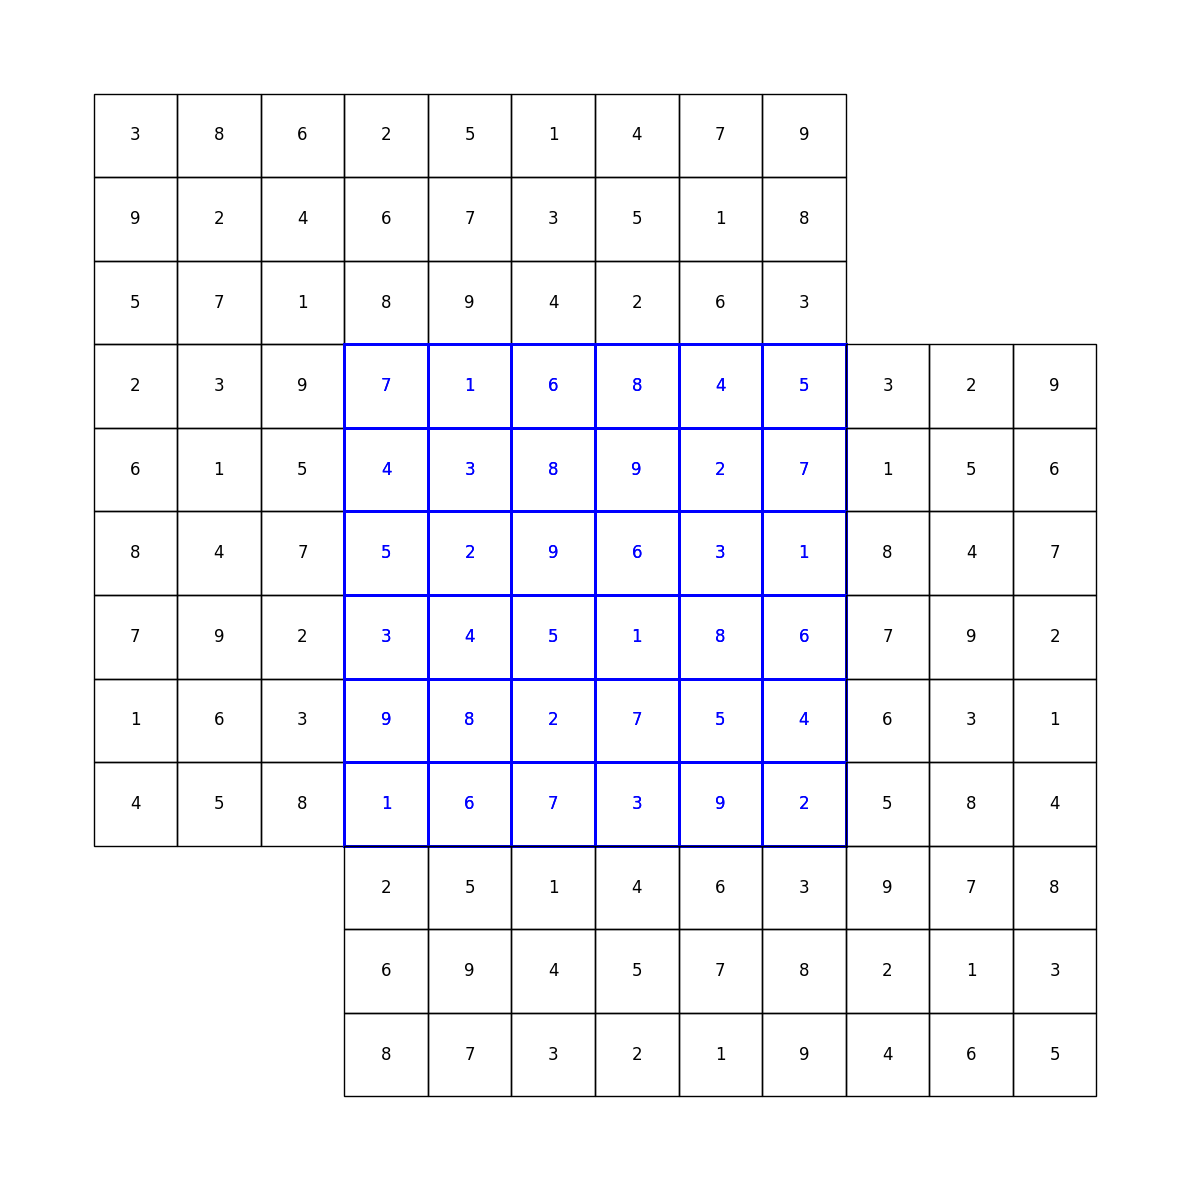

In [9]:
grid1 = [
    [3,0,0,0,0,0,0,7,0],
    [0,2,4,0,0,3,0,1,8],
    [0,0,0,8,9,0,0,0,3],
    [0,0,0,0,0,6,8,0,5],
    [6,0,5,4,3,0,9,0,0],
    [0,0,7,5,0,0,6,0,0],
    [7,0,2,0,0,0,0,8,0],
    [0,6,3,0,0,2,0,0,0],
    [0,5,0,0,0,0,3,0,2]
]
grid2 = [
    [0,0,6,8,0,5,0,2,9],
    [4,3,0,9,0,0,0,0,6],
    [5,0,0,6,0,0,0,4,0],
    [0,0,0,0,8,0,7,0,0],
    [0,0,2,0,0,0,0,3,0],
    [0,0,0,3,0,2,0,0,0],
    [0,0,1,4,0,3,0,0,0],
    [0,9,4,5,0,0,0,0,0],
    [8,7,0,0,0,0,4,6,5]
]

common_blocks = [
    (0, 1, 1, 1, 0, 0),
    (0, 1, 2, 1, 0, 1),
    (0, 2, 1, 1, 1, 0),
    (0, 2, 2, 1, 1, 1)
                 ]

try:
    overlaps = expand_overlaps_to_linked_cells(common_blocks)
    solutions = solve_n_sudoku([grid1, grid2], common_blocks)
    plot_sudoku_grids(solutions, overlaps)
except ValueError as e:
    print("Ошибка:", e)

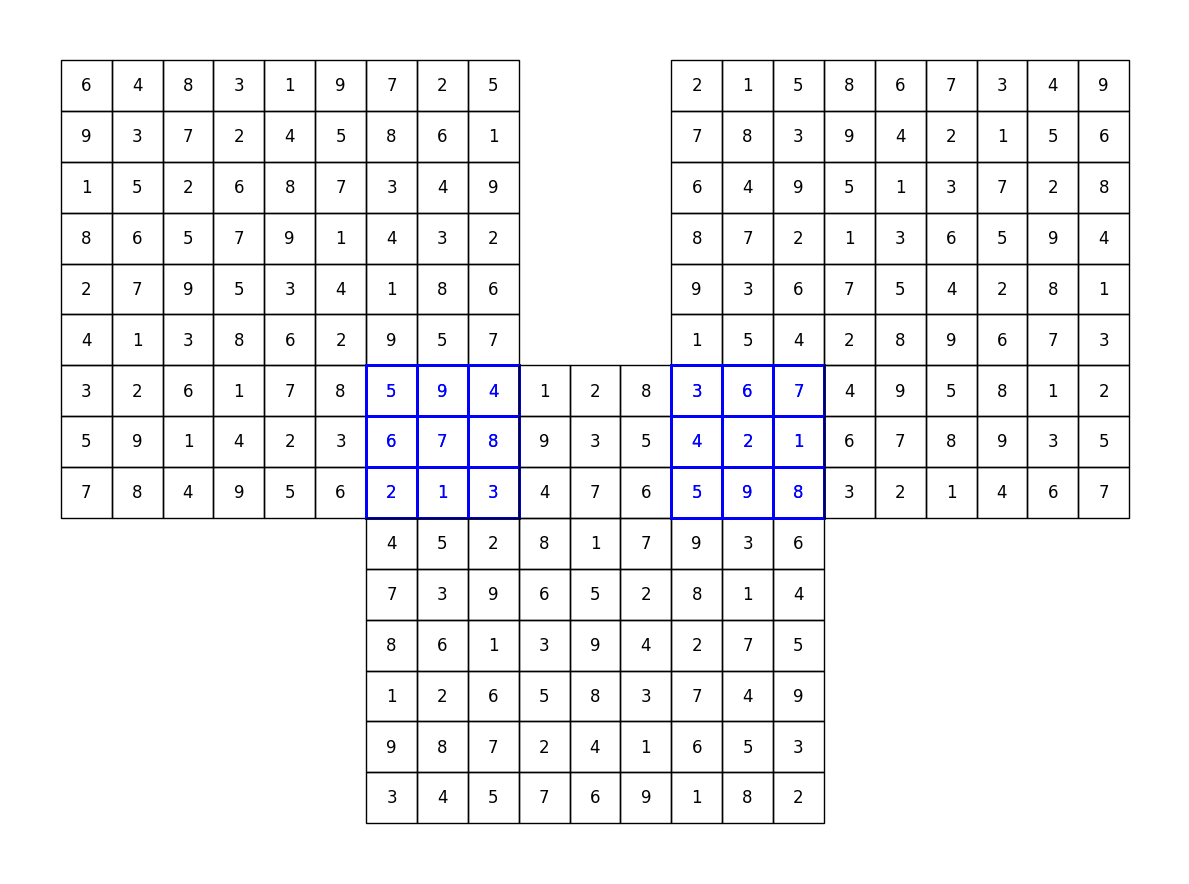

In [7]:
grid1 = [
    [6,0,8,0,1,0,0,0,0],
    [0,0,7,0,4,0,8,0,1],
    [0,0,0,0,0,0,0,0,9],
    [0,6,0,7,0,0,0,3,0],
    [0,7,0,5,0,4,0,0,0],
    [0,0,0,8,0,0,9,5,0],
    [0,0,0,0,7,8,0,0,0],
    [5,0,1,0,0,0,0,0,0],
    [0,0,4,0,0,6,0,0,0]
]

grid3 = [
    [0,0,0,0,6,0,3,0,9],
    [7,0,3,0,4,0,1,0,0],
    [6,0,0,0,0,0,0,0,0],
    [0,7,0,0,0,6,0,9,0],
    [0,0,0,7,0,4,0,8,0],
    [0,5,4,0,0,9,0,0,0],
    [0,0,0,4,9,0,0,0,0],
    [0,0,0,0,0,0,9,0,5],
    [0,0,0,3,0,0,4,0,0]
]

grid2 = [
    [0,0,0,1,0,8,0,0,0],
    [0,0,0,0,3,0,0,0,0],
    [0,0,0,0,7,0,0,0,0],
    [4,0,0,0,0,0,0,0,6],
    [0,0,0,6,5,2,0,0,0],
    [0,0,1,0,0,0,2,0,0],
    [0,0,0,5,0,3,0,0,0],
    [0,8,7,0,0,0,6,5,0],
    [0,4,0,0,0,0,0,8,0]
]
common_blocks = [
    (0, 2, 2, 1, 0, 0),
    (2, 2, 0, 1, 0, 2)
]

try:
    overlaps = expand_overlaps_to_linked_cells(common_blocks)
    solutions = solve_n_sudoku([grid1, grid2, grid3], common_blocks)
    plot_sudoku_grids(solutions, overlaps)
except ValueError as e:
    print("Ошибка:", e)